In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
import os


In [4]:
os.environ['THEANO_FLAGS'] = 'device=gpu1'

In [5]:
import sys
sys.path.append('/home/matsui-k/projects/d-rcn')
from scripts.core import TN_utils
reload(TN_utils)

Using gpu device 1: Tesla K40m (CNMeM is disabled, CuDNN not available)


<module 'scripts.core.TN_utils' from '/home/matsui-k/projects/d-rcn/scripts/core/TN_utils.pyc'>

In [4]:
proj_path = '/home/matsui-k/projects/d-rcn/'

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('viridis')
import scipy.io as sio
import time
import sys
sys.path.append('/home/matsui-k/projects/d-rcn')
from scripts.core import TN_utils, optimizers, compling_multiorder, models_multi_order, blocks
reload(TN_utils)
reload(models_multi_order)
reload(compling_multiorder)
reload(blocks)

<module 'scripts.core.blocks' from '/home/matsui-k/projects/d-rcn/scripts/core/blocks.pyc'>

In [6]:
input_tensors, output_tensors = TN_utils.load_blind(input_L=4, output_L=4, folder_name='in8out8')

[(0, 1), (1, 6), (6, 15)] [(0, 1), (1, 6), (6, 15)]
(855000, 2)
(855000, 10)
(855000, 18)
(855000, 2)
(855000, 10)
(855000, 18)


In [7]:
train_input, train_output, test_input, test_output, input_coef, output_coef = TN_utils.pre_blind(input_tensors, output_tensors, N=1000)

In [8]:
print [ti.shape for ti in train_input]
print [to.shape for to in train_output]
print [ti.shape for ti in test_input]

[(800, 2, 1), (800, 10, 1), (800, 18, 1)]
[(800, 2), (800, 10), (800, 18)]
[(199, 2, 1), (199, 10, 1), (199, 18, 1)]


In [9]:
nn = models_multi_order.Rcn2layer_multioreder(
        j_input_list=[0, 2, 4], j_output=2, n_input_tensors_list=[1, 1, 1],
        n_hidden_tensors=10, func_key_list=['relu', 'linear'])

In [11]:
%%time
results = compling_multiorder.compile(
        train_input, train_output[1], test_input, test_output[1],
        model=nn, make_updates=optimizers.adam)
f_train, f_training_error, f_test_error, f_output, param_list = results

[(0, 2), (2, 2), (2, 4), (4, 4)]
do ordinary forward

/home/matsui-k/projects/d-rcn/scripts/core/compling_multiorder.py:65: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 8 is not part of the computational graph needed to compute the outputs: beta.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')
/home/matsui-k/projects/d-rcn/scripts/core/compling_multiorder.py:65: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 9 is not part of the computational graph needed to compute the outputs: t.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')
/home/matsui-k/projects/d-rcn/scripts/core/comp


[(0, 2), (2, 2), (2, 4), (4, 4)]
CPU times: user 3min 42s, sys: 3.77 s, total: 3min 46s
Wall time: 3min 47s


/home/matsui-k/projects/d-rcn/scripts/core/compling_multiorder.py:71: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 4 is not part of the computational graph needed to compute the outputs: t.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')


In [12]:
batch_size = 100
N = train_input[0].shape[0]
n_batchs = N // batch_size
index_list = range(N)
index_list = np.asarray(np.random.permutation(index_list), dtype=np.int32)

N_test = test_input[0].shape[0]
test_index_list = np.asarray(range(N_test), dtype=np.int32)

n_epochs = 201
interval = 10
training_error_array = np.zeros((n_epochs // interval + 2,))
test_error_array = np.zeros((n_epochs // interval + 2,))

alpha = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 10e-8
t = 0.

beta = 0.01

i_batch = 0
training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
training_error_array[0] = training_error
test_error = f_test_error(i_batch, test_index_list, batch_size)[0]
test_error_array[0] = test_error

start_time = time.clock()
for i_epoch in xrange(n_epochs):
    index_list = np.random.permutation(index_list)
    test_index_list = np.random.permutation(test_index_list)

    for i_batch in xrange(n_batchs):
        t = t + 1.
        f_train(i_batch, index_list, batch_size, alpha, beta1, beta2, eps, t, beta, t)
        
    if i_epoch % interval == 0:
        training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
        training_error_array[i_epoch // interval + 1] = training_error
        test_error = f_test_error(0, test_index_list, batch_size)[0]
        test_error_array[i_epoch // interval + 1] = test_error

        alpha = alpha * 0.95
        print i_epoch, training_error, test_error
print time.clock() - start_time

0 0.100886106491 0.100449062884
10 0.0392731688917 0.038278337568
20 0.00907905865461 0.00821858458221
30 0.00874009914696 0.00634075701237
40 0.00390193914063 0.00705484813079
50 0.0088183125481 0.00630725268275
60 0.00526088802144 0.00525761535391
70 0.0037439155858 0.00674514565617
80 0.00350523670204 0.00462317280471
90 0.0063253575936 0.00440300023183
100 0.00283076707274 0.00565835600719
110 0.00751993292943 0.00639170547947
120 0.00559611758217 0.00877792667598
130 0.0058065271005 0.0078706247732
140 0.0035517946817 0.00413328735158
150 0.00307892076671 0.00598138896748
160 0.00519970571622 0.00560610368848
170 0.00499126221985 0.0044780713506
180 0.00330781750381 0.00764600280672
190 0.00574355898425 0.00648834323511
200 0.00309436884709 0.00601258827373
87.412343


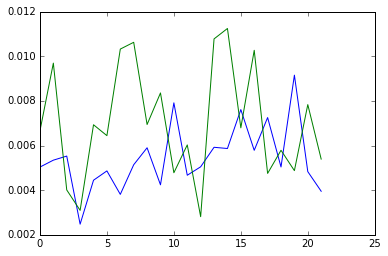

In [19]:
# まあbatch_size=100やからしょうがない
plt.plot(training_error_array)
plt.plot(test_error_array)

In [15]:
pred_train2 = TN_utils.predict_original_feature_multiorder(f_output, [tens[:, np.newaxis, :] for tens in input_tensors],
                                            np.array(input_coef)[:, np.newaxis], 34)

In [16]:
pred_train2.shape

(855000, 34)

(array([  4.72048000e+05,   2.69782000e+05,   7.06750000e+04,
          2.35000000e+04,   9.62300000e+03,   4.24700000e+03,
          2.81100000e+03,   1.72000000e+03,   5.15000000e+02,
          7.90000000e+01]),
 array([ 0.38678655,  0.55489427,  0.72300198,  0.8911097 ,  1.05921741,
         1.22732513,  1.39543284,  1.56354056,  1.73164827,  1.89975599,
         2.0678637 ]),
 <a list of 10 Patch objects>)

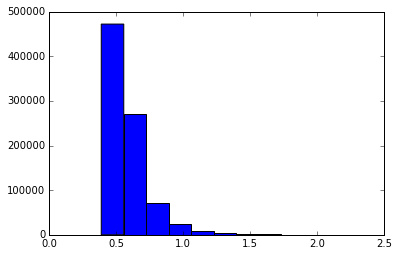

In [17]:
# L=8のhistも書くべき
plt.hist(np.linalg.norm(pred_train2, axis=1))

In [14]:
from datetime import datetime

In [27]:
str(datetime.now()).split('.')[0]

'2016-08-19 14:54:17'

In [30]:
'n_hidden_tensors, func_key_list, N, batch_size, lr_decay, training_error_array, test_error_array'.split(', ')

['n_hidden_tensors',
 'func_key_list',
 'N',
 'batch_size',
 'lr_decay',
 'training_error_array',
 'test_error_array']